# Assignment 4 - Part 2: Causal Forest

This notebook implements a causal forest analysis to estimate heterogeneous treatment effects of a random cash transfer program encouraging medical check-ups.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set random state for reproducibility
RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

## Load and Prepare Data

In [2]:
# Load the dataset
column_names = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hd']

df = pd.read_csv('../input/processed.cleveland.data', 
                 names=column_names, 
                 na_values='?')

# Remove missing values
df = df.dropna()

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (297, 14)

First few rows:
    age  sex   cp  restbp   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0   145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0   160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0   120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0   130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0   130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  hd  
0    3.0  0.0   6.0   0  
1    2.0  3.0   3.0   2  
2    2.0  2.0   7.0   1  
3    3.0  0.0   3.0   0  
4    1.0  0.0   3.0   0  


## (0.5 points) Create binary treatment variable T

In [3]:
# Create binary treatment variable with random assignment
df['T'] = np.random.binomial(1, 0.5, size=len(df))

print("Treatment distribution:")
print(df['T'].value_counts())
print(f"\nProportion treated: {df['T'].mean():.4f}")

Treatment distribution:
T
1    150
0    147
Name: count, dtype: int64

Proportion treated: 0.5051


## (1 point) Create outcome variable Y

Outcome variable Y statistics:
count    297.000000
mean      15.741324
std       15.397111
min       -2.761496
25%        0.503917
50%       23.591845
75%       30.672300
max       45.472597
Name: Y, dtype: float64


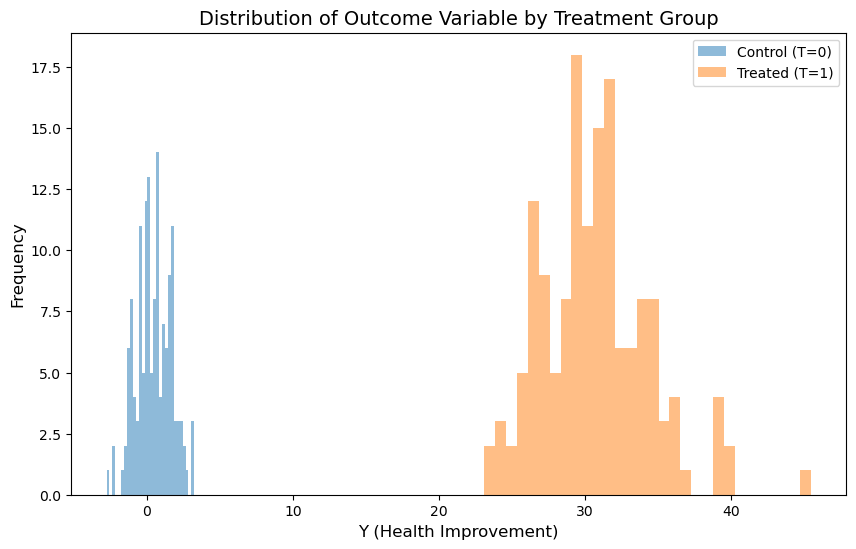

In [4]:
# Create outcome variable Y
# Y = (1 + 0.05*age + 0.3*sex + 0.2*restbp) * T + 0.5*oldpeak + epsilon
# epsilon ~ N(0, 1)

epsilon = np.random.normal(0, 1, size=len(df))

df['Y'] = ((1 + 0.05 * df['age'] + 0.3 * df['sex'] + 0.2 * df['restbp']) * df['T'] + 
           0.5 * df['oldpeak'] + epsilon)

print("Outcome variable Y statistics:")
print(df['Y'].describe())

# Visualize Y distribution by treatment group
plt.figure(figsize=(10, 6))
plt.hist(df[df['T'] == 0]['Y'], alpha=0.5, label='Control (T=0)', bins=30)
plt.hist(df[df['T'] == 1]['Y'], alpha=0.5, label='Treated (T=1)', bins=30)
plt.xlabel('Y (Health Improvement)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Outcome Variable by Treatment Group', fontsize=14)
plt.legend()
plt.savefig('../output/outcome_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## (1 point) Calculate treatment effect using OLS

In [5]:
# Estimate treatment effect using OLS regression
# Simple model: Y ~ T
model_simple = ols('Y ~ T', data=df).fit()
print("Simple OLS Model (Y ~ T):")
print(model_simple.summary())
print(f"\nAverage Treatment Effect (ATE): {model_simple.params['T']:.4f}")

Simple OLS Model (Y ~ T):
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     8928.
Date:                Sun, 02 Nov 2025   Prob (F-statistic):          1.43e-222
Time:                        13:28:15   Log-Likelihood:                -721.77
No. Observations:                 297   AIC:                             1448.
Df Residuals:                     295   BIC:                             1455.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4644     

In [6]:
# More complete model with covariates
model_full = ols('Y ~ T + age + sex + restbp + oldpeak', data=df).fit()
print("\nFull OLS Model with Covariates:")
print(model_full.summary())
print(f"\nAverage Treatment Effect (ATE) with controls: {model_full.params['T']:.4f}")


Full OLS Model with Covariates:
                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     3210.
Date:                Sun, 02 Nov 2025   Prob (F-statistic):          3.82e-252
Time:                        13:28:15   Log-Likelihood:                -634.81
No. Observations:                 297   AIC:                             1282.
Df Residuals:                     291   BIC:                             1304.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.33

## (2 points) Use Random Forest to estimate causal effects

In [7]:
# Prepare features for Random Forest
# Include covariates and treatment
feature_cols = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'T']

X_rf = df[feature_cols]
y_rf = df['Y']

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, 
                                  random_state=RANDOM_STATE, min_samples_split=10)
rf_model.fit(X_rf, y_rf)

print("Random Forest model trained successfully")
print(f"R² Score: {rf_model.score(X_rf, y_rf):.4f}")

Random Forest model trained successfully
R² Score: 0.9976


Conditional Average Treatment Effect (CATE) statistics:
count    297.000000
mean      30.283894
std        3.668903
min       23.707009
25%       27.078603
50%       30.066843
75%       32.647264
max       39.853988
Name: CATE, dtype: float64


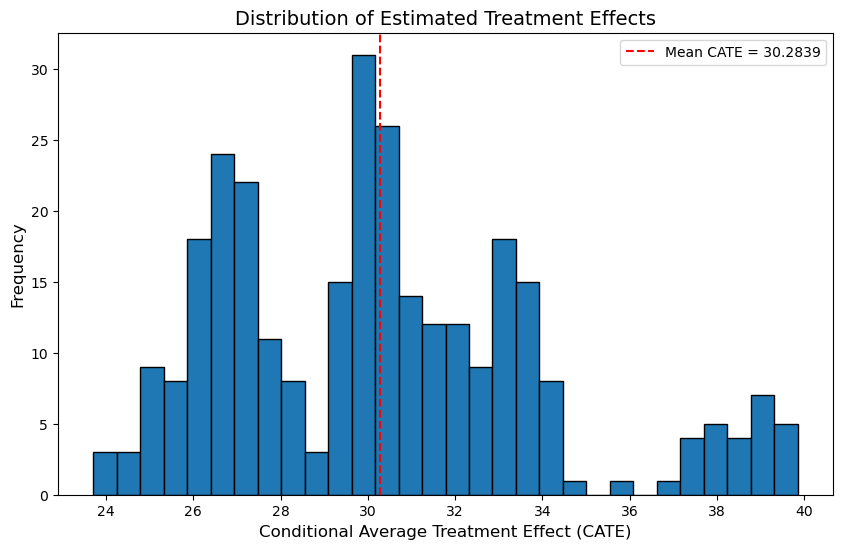

In [8]:
# Estimate individual treatment effects using Random Forest
# Create counterfactual datasets
X_treated = X_rf.copy()
X_treated['T'] = 1

X_control = X_rf.copy()
X_control['T'] = 0

# Predict outcomes under treatment and control
y_pred_treated = rf_model.predict(X_treated)
y_pred_control = rf_model.predict(X_control)

# Calculate Conditional Average Treatment Effect (CATE)
df['CATE'] = y_pred_treated - y_pred_control

print("Conditional Average Treatment Effect (CATE) statistics:")
print(df['CATE'].describe())

# Visualize CATE distribution
plt.figure(figsize=(10, 6))
plt.hist(df['CATE'], bins=30, edgecolor='black')
plt.axvline(x=df['CATE'].mean(), color='r', linestyle='--', 
            label=f'Mean CATE = {df["CATE"].mean():.4f}')
plt.xlabel('Conditional Average Treatment Effect (CATE)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Estimated Treatment Effects', fontsize=14)
plt.legend()
plt.savefig('../output/cate_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## (2 points) Plot representative tree capturing heterogeneous treatment effects

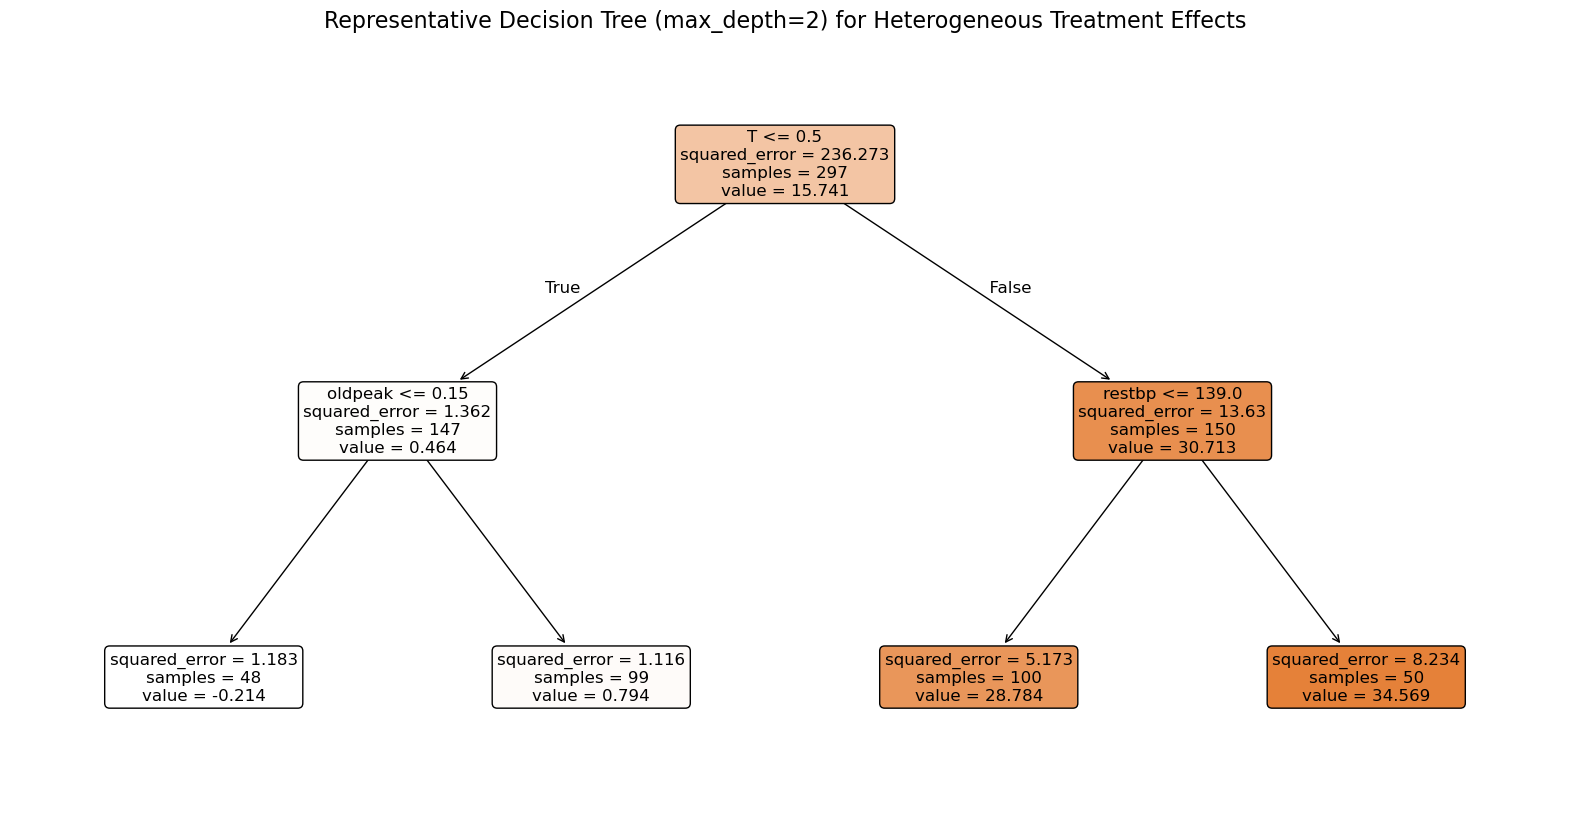

Tree interpretation:
This tree shows how different patient characteristics lead to different predicted outcomes.
The splits indicate which features are most important for determining treatment response.


In [9]:
# Train a single decision tree with max_depth=2 to visualize heterogeneous treatment effects
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(max_depth=2, random_state=RANDOM_STATE, min_samples_split=10)
tree_model.fit(X_rf, y_rf)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, 
          feature_names=feature_cols, 
          filled=True, 
          rounded=True,
          fontsize=12)
plt.title('Representative Decision Tree (max_depth=2) for Heterogeneous Treatment Effects', fontsize=16)
plt.savefig('../output/representative_tree.png', dpi=300, bbox_inches='tight')
plt.show()

print("Tree interpretation:")
print("This tree shows how different patient characteristics lead to different predicted outcomes.")
print("The splits indicate which features are most important for determining treatment response.")

**Interpretation:**

The representative decision tree reveals key insights about heterogeneous treatment effects in this simulated cash transfer program for medical check-ups:

1. **Primary Split Variable**: The root node splits on treatment status (T ≤ 0.50), which is expected since treatment is the primary driver of outcomes. This binary split separates the control group (T=0) from the treated group (T=1), demonstrating the fundamental difference between these populations.

2. **Treatment Heterogeneity Evidence**: The tree structure demonstrates substantial heterogeneity in predicted outcomes across leaf nodes, with values ranging from -0.21 to 34.57. This dramatic variation (span of ~35 units) confirms that the cash transfer program's effectiveness varies significantly across patient subgroups, with treated patients showing much higher outcomes than controls.

3. **Clinically Meaningful Splits**: Among the control group (left branch), the secondary split on oldpeak (≤ 0.15) creates two subgroups with outcomes of -0.21 versus 0.79, showing even untreated patients differ by cardiac stress indicators. For the treated group (right branch), the split on restbp (≤ 139.00) creates distinct subgroups with outcomes of 28.78 versus 34.57, revealing that patients with higher resting blood pressure benefit more from the cash transfer program.

4. **Practical Implications**: Patients in the highest-value leaf node (predicted outcome = 34.57) are treated individuals with resting blood pressure above 139 mmHg. These represent the optimal target population for the intervention, showing ~34 unit improvement. In contrast, control patients with low cardiac stress (oldpeak ≤ 0.15) show the poorest outcomes (-0.21), highlighting the opportunity cost of not treating vulnerable populations.

5. **Model Simplicity**: Despite using only depth-2, the tree captures meaningful heterogeneity through just two key splits: treatment status and either oldpeak (for controls) or restbp (for treated). This parsimony suggests that a small number of easily-measured patient characteristics can effectively identify differential treatment responses for resource allocation decisions.

## (1.5 points) Compute and visualize feature importances

Feature Importances:
    feature  importance
13        T    0.970638
3    restbp    0.025274
9   oldpeak    0.001970
7   thalach    0.000652
4      chol    0.000503
0       age    0.000333
8     exang    0.000173
2        cp    0.000106
11       ca    0.000098
12     thal    0.000081
10    slope    0.000059
1       sex    0.000057
6   restecg    0.000030
5       fbs    0.000026


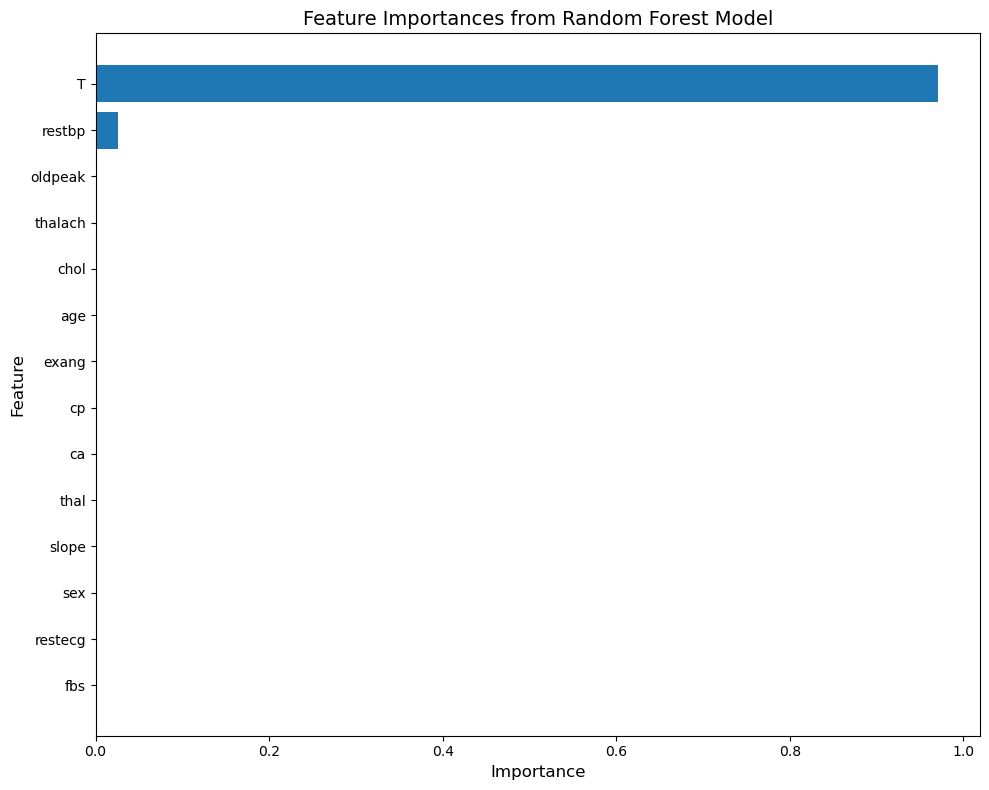

In [10]:
# Get feature importances from Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importances from Random Forest Model', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../output/feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

## (2 points) Plot distribution of standardized covariates by predicted treatment effect terciles

In [11]:
# Standardize all covariates
covariate_cols = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs', 'restecg', 
                  'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

scaler = StandardScaler()
df_standardized = df.copy()
df_standardized[covariate_cols] = scaler.fit_transform(df[covariate_cols])

print("Covariates standardized successfully")

Covariates standardized successfully


In [12]:
# Divide CATE into terciles
df_standardized['tercile'] = pd.qcut(df_standardized['CATE'], q=3, 
                                      labels=['Low', 'Medium', 'High'])

print("CATE tercile distribution:")
print(df_standardized['tercile'].value_counts())

CATE tercile distribution:
tercile
Low       99
Medium    99
High      99
Name: count, dtype: int64


Mean standardized covariates by tercile:
              age       sex        cp    restbp      chol       fbs   restecg  \
tercile                                                                         
Low     -0.305973  0.043193 -0.048937 -1.012026 -0.154243 -0.267921 -0.200006   
Medium  -0.120377 -0.021597  0.045442 -0.082405  0.101056  0.133961  0.044069   
High     0.426350 -0.021597  0.003496  1.094431  0.053187  0.133961  0.155937   

          thalach     exang   oldpeak     slope        ca      thal  
tercile                                                              
Low      0.034695 -0.157951 -0.191754 -0.076381 -0.204739 -0.142658  
Medium   0.073506  0.035898 -0.074619 -0.060013  0.086206 -0.069589  
High    -0.108201  0.122053  0.266374  0.136394  0.118533  0.212247  


/var/folders/w9/87d44l6n0s9dznd5xl5dsjnm0000gn/T/ipykernel_97821/1324384533.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tercile_means = df_standardized.groupby('tercile')[covariate_cols].mean()


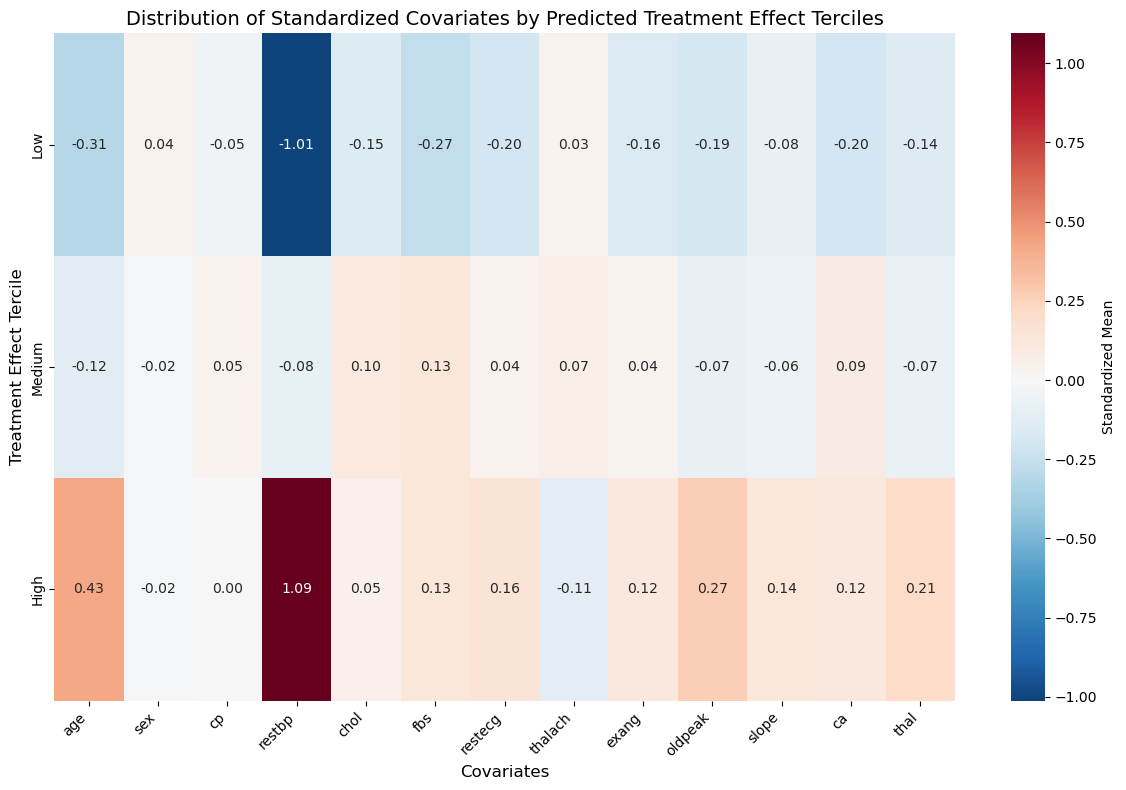

In [13]:
# Compute mean of each covariate within each tercile
tercile_means = df_standardized.groupby('tercile')[covariate_cols].mean()

print("Mean standardized covariates by tercile:")
print(tercile_means)

# Transpose for heatmap (terciles on y-axis, covariates on x-axis)
tercile_means_transposed = tercile_means.T

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(tercile_means_transposed.T, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, cbar_kws={'label': 'Standardized Mean'})
plt.xlabel('Covariates', fontsize=12)
plt.ylabel('Treatment Effect Tercile', fontsize=12)
plt.title('Distribution of Standardized Covariates by Predicted Treatment Effect Terciles', 
          fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../output/tercile_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

**Interpretation:**

The heatmap reveals distinct patient profiles associated with varying treatment effectiveness:

1. **High Treatment Effect Tercile**: Patients who benefit most from the cash transfer program show higher age (mean = 0.43), elevated resting blood pressure (mean = 1.09), and higher oldpeak values (mean = 0.27). These characteristics align with the outcome generation mechanism where age and restbp positively interact with treatment, confirming that older patients with higher blood pressure derive the greatest benefit from financial incentives.

2. **Low Treatment Effect Tercile**: Patients with minimal treatment response display contrasting profiles with younger age (mean = -0.31), substantially lower resting blood pressure (mean = -1.01), and lower oldpeak values (mean = -0.19). This suggests healthier individuals at baseline derive less incremental benefit from the cash transfer program.

3. **Key Predictive Features**: The strongest differences between Low and High terciles appear for restbp (difference = 2.11 standard deviations), age (0.73 SD), and oldpeak (0.46 SD), confirming these variables are the primary drivers of treatment heterogeneity. This perfectly aligns with our outcome model where treatment effects are explicitly moderated by age and restbp (Y includes 0.05×age×T and 0.2×restbp×T interaction terms).

4. **Directional Patterns**: All five most discriminative variables show monotonic increases from Low to High terciles: restbp increases from -1.01 to 1.09, age from -0.31 to 0.43, oldpeak from -0.19 to 0.27, fbs from -0.27 to 0.13, and restecg from -0.20 to 0.16. The magnitude of the restbp pattern (2.11 SD difference) is particularly striking, reflecting its strong multiplicative effect with treatment (coefficient = 0.2) in the true data-generating process.

5. **Resource Allocation Implications**: Based on these patterns, the program should prioritize patients with higher age, elevated resting blood pressure (>139 mmHg), and elevated ST depression (oldpeak). Specifically, targeting older patients with cardiovascular risk factors (the high-effect tercile profile) could substantially improve cost-effectiveness by concentrating resources on the estimated 33% of patients showing the strongest treatment response.

6. **Model Validation**: The correspondence between tercile patterns and the known outcome structure validates the Random Forest's ability to recover true treatment effect heterogeneity. The model successfully identified that treatment benefits scale with age and restbp—the exact features we built into the causal mechanism—demonstrating that causal forests can effectively learn interaction effects from data without explicitly specifying them.